# K-Means Clustering

K-means clustering is a useful technique for identifying natural groupings within a dataset and uncovering relationships between variables.
In the context of this project, it is used to detect distinct customer segments based on their likelihood of booking an energy consultation. Understanding the typical characteristics of these groups can support the creation of ideal customer profiles and enable more targeted, data-driven marketing campaigns.

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Loading the dataset
data = pd.read_excel('combined_data.xlsx')
data.head()

,age,gender,household_size,occupation_status,income,house_type,house_age,house_size,location,energy_bill,...,knowledge_energy,energy_awareness,attitude_energy_reduction,investment_willingness,belief_climate_change,financial_awareness,perceived_efficiency,environment_concern,previous_renovations,booked_energy_consultation
0,26,Male,1,Unemployed,20108,Multi-family House,2020,120,Rural,103,...,4,4,2,1,Yes,No,1,2,10,No
1,28,Female,3,Employed,53000,Detached,2020,400,Urban,170,...,2,4,5,3,Yes,No,2,5,1,Considered but not used
2,52,Male,2,Employed,86352,Detached,1953,253,Urban,165,...,2,2,3,4,Yes,No,2,1,7,Yes
3,17,Other,1,Employed,27633,Detached,2018,108,Urban,102,...,4,4,2,1,Yes,No,4,2,7,No
4,20,Male,1,Employed,25011,Detached,2020,110,Urban,106,...,4,4,2,1,Yes,No,1,2,9,No


### Preprocessing the Data

Preprocessing is described in detail in 02_Cleaning_Preprocessing.ipynb.
Since different modeling methods have different input requirements (e.g. scaling, encoding), the relevant preprocessing steps are repeated in each modeling notebook to ensure compatibility with the respective algorithm.

In [4]:
# Identify numerical and categorical columns
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns

# One-hot encode the categorical variables
encoder = OneHotEncoder(sparse_output=False)
categorical_encoded = encoder.fit_transform(data[categorical_cols])
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Scale the numerical variables
scaler = StandardScaler()

#scaler = MinMaxScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Concatenate the scaled numerical data and encoded categorical data
data_preprocessed = pd.concat([data[numerical_cols].reset_index(drop=True), categorical_encoded_df.reset_index(drop=True)], axis=1)

### Applying the Elbow Method

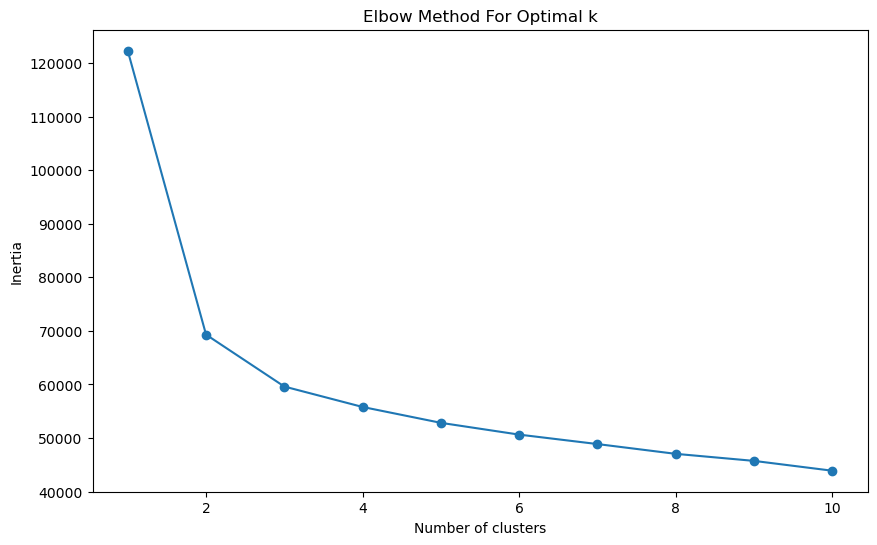

In [6]:
# Calculate distortion for a range of number of cluster
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=10)
    kmeans.fit(data_preprocessed)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

The biggest decrease in gradient happens between k=2 and k=3, so 3 seems to be the optimal amount of clusters

## Applying K-Means Clustering with k = 3

In [8]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(data_preprocessed)

# Assign clusters back to the original data
data['cluster'] = kmeans.labels_

### Visualizing the Clusters with PCA

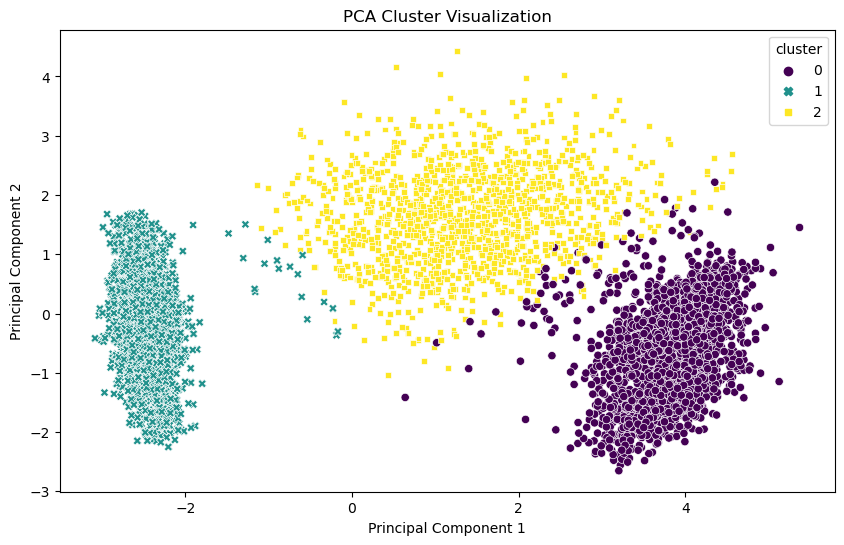

In [9]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_preprocessed)

# Create a DataFrame with PCA results and the cluster labels
data_pca_df = pd.DataFrame(data=data_pca, columns=['Principal Component 1', 'Principal Component 2'])
data_pca_df['cluster'] = kmeans.labels_

# Plotting the results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='cluster', data=data_pca_df, palette='viridis', style='cluster', markers=True)
plt.title('PCA Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig('K-means Clustering.png')
plt.show()

The three groups can be seen very clearly.

### Exporting Centroids and retranslating them

After fitting the K-Means model, the resulting cluster centroids were exported for further interpretation. Since the model was trained on scaled and encoded data, the centroids were retranslated back into their original (human-readable) feature space. This allows for a clearer understanding of the typical characteristics of each cluster and supports the creation of meaningful customer profiles.

In [11]:
centroids = kmeans.cluster_centers_

# Reverse scaling for numerical columns
centroids_numerical = scaler.inverse_transform(centroids[:, :len(numerical_cols)])

# Reformatting the categorical data to show the most likely category
centroids_categorical = centroids[:, len(numerical_cols):]
most_likely_categories = encoder.inverse_transform(centroids_categorical)

# Creating DataFrame for the numerical centroids
centroids_df_numerical = pd.DataFrame(centroids_numerical, columns=numerical_cols)

# Creating DataFrame for the most likely categories
centroids_df_categorical = pd.DataFrame(most_likely_categories, columns=categorical_cols)

# Combining the two into a final centroids DataFrame
final_centroids_df = pd.concat([centroids_df_numerical, centroids_df_categorical], axis=1)

In [12]:
final_centroids_df = final_centroids_df.round(0)
for col in final_centroids_df.select_dtypes(include=['float64']).columns:
    final_centroids_df[col] = final_centroids_df[col].astype(int)

In [32]:
final_centroids_df.head()

,age,household_size,income,house_age,house_size,energy_bill,knowledge_energy,energy_awareness,attitude_energy_reduction,investment_willingness,...,environment_concern,previous_renovations,gender,occupation_status,house_type,location,energy_source,belief_climate_change,financial_awareness,booked_energy_consultation
0,41,3,46814,1989,160,133,4,4,4,2,...,4,4,Female,Employed,Multi-family House,Rural,Non-renewable sources,Yes,No,Considered but not used
1,25,1,25108,2015,110,106,4,4,2,1,...,2,5,Male,Employed,Detached,Rural,Renewable sources,Yes,No,No
2,54,2,74433,1965,280,159,2,2,3,4,...,3,5,Male,Employed,Detached,Rural,Non-renewable sources,Yes,No,Yes
